In [1]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm
import time
import xgboost as xgb
seed = 12345

In [2]:
# Visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize = False, title = None, fig_width = None, fig_height = None, cmap = None):
    '''
    09/11/2019, Kefu Zhu

    Visualize the confusion matrix.

    Features:
    1. Normalize the confusion matrix if `normalize = True`
    '''
    # Required library
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Default title if not provided
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Default color for visualization (Blue)
    if not cmap:
        cmap = plt.cm.Blues

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Labels appear in the data
    classes = unique_labels(y_true, y_pred)

    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Create fig and ax for visualization
    if fig_width and fig_height:
        fig, ax = plt.subplots(figsize = (fig_width, fig_height))
    else:
        fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    # Adjust the layout so fits into figure area
    fig.tight_layout()

    return ax

In [3]:
# Colored 3D plot
def scatter_3D(xyz_list, xlab, ylab, zlab, angle = 30, alpha = 0.5, legend = None, fig_width = None, fig_height = None):
    '''
    09/17/2019, Kefu Zhu

    Input: xyz_list = [(x1,y1,z1), (x2,y2,z2), ...]
    Output: 3D plot that color data points for different classes
            e.g.: Red - (x1,y1,z1), Blue - (x2,y2,z2), ....
    '''
    
    # Import library
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import itertools
    
    # Create fig and ax for visualization
    if fig_width and fig_height:
        fig = plt.figure(figsize = (fig_width, fig_height))
    else:
        fig = plt.figure()
       
    # Create 3D ax object 
    ax = fig.add_subplot(111, projection='3d')
    # Make iterable marker and color 
    marker = itertools.cycle(('o','+','?'))
    color = itertools.cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'))
    
    # Note: Each class will get assigned a different combination of color and marker, this function can
    #       label up to 24 (8 colors x 3 markers) different classes
    #     - The function will iterate over color first, then the marker

    # Current color cycle
    color_cycle = 0
    # Initialize the marker and color
    init_marker = next(marker)
    init_color = next(color)
    # Create variables to capture the current marker and color
    cur_marker = init_marker
    cur_color = init_color
    
    # Loop over each class
    for xyz in xyz_list:
        # Unpack the x,y,z coordinates for all the data points for the current class
        x,y,z = xyz
        
        # If the color cycle is zero
        if color_cycle == 0:
            # Plot the data with current color and marker (No change at all)
            ax.scatter(x, y, z, c = cur_color, marker = cur_marker, alpha = alpha)
            # Increment the color cycle
            color_cycle += 1
        # If the color cycle does not reach the maximum (8)
        elif color_cycle < 8:
            # Plot the data with the same marker but use a different color (next color in the color list)
            ax.scatter(x, y, z, c = next(color), marker = cur_marker, alpha = alpha)
            # Increment the color cycle
            color_cycle += 1
        # If the color cycle reaches the maximum (8)
        elif color_cycle == 8:
            # Use a different marker (next marker in the list)
            cur_marker = next(marker)
            # Use next color in the list (Should cycle back to the first color in the color list)
            cur_color = next(color)
            # Plot the data with a different marker and different color
            ax.scatter(x, y, z, c = cur_color, marker = cur_marker, alpha = alpha)
            # Reset the color cycle since we are back to the first color in list
            color_cycle = 0
        else:
            # This should not happen. BUG!
            print('Ooops! Something went wrong X(\ncolor_cycle: {}, cur_marker:{}, cur_color:{}'.format(color_cycle, cur_marker, cur_color))
    
    # Set the axis names
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_zlabel(zlab)
    # View the 3D plot from a certain angle
    ax.view_init(azim=angle)
    # Add the legend
    ax.legend(legend)
    # Show the plot
    plt.show()

    # Return the 3D plot object
    return ax

In [4]:
# Correlation heatmap
def heatmap_corr(df, fig_width = None, fig_height = None):
    '''
    09/17/2019, Kefu Zhu

    Input:
    Output:
    '''

    # Import library
    import matplotlib.pyplot as plt
    # Create fig and ax for visualization
    if fig_width and fig_height:
        fig, ax = plt.subplots(figsize = (fig_width, fig_height))
    else:
        fig, ax = plt.subplots()
    ax = sns.heatmap(df.corr(), vmin = -1, vmax = 1, square = True, cmap = sns.diverging_palette(220, 10, as_cmap=True))

    return ax

In [5]:
# Variation of model accuracy based on # of top features
def acc_vs_feature(xgb, acc_target, X_train, y_train, X_test, y_test):
    
    # Import library
    from sklearn.feature_selection import SelectFromModel
    from xgboost import XGBClassifier
    import warnings
    warnings.filterwarnings("ignore")

    # Initialize the dataframe to store information in the following computation
    acc_df = pd.DataFrame({'n': 1+ np.arange(X_train.shape[1]),
                           'accuracy': None})
    
    # make predictions for test data and evaluate
    y_pred = xgb.predict(X_test)
    accuracy = 100 * accuracy_score(y_true = y_test, y_pred = y_pred)
    print('Accuracy: {:.2f}%'.format((accuracy)))

    thresholds = sorted(xgb.feature_importances_, reverse = True)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        accuracy = 100 * accuracy_score(y_true = y_test, y_pred = y_pred)
        n = select_X_train.shape[1]
        print('Thresh={:.3f}, n={}, Accuracy: {:.2f}%'.format(thresh, n, accuracy))
        acc_df.accuracy[n-1] = accuracy
        
        if accuracy > 90:
            return acc_df.dropna()

In [6]:
# PCA transformation
def pca_transform(X_train, X_test):
    '''
    09/17/2019, Kefu Zhu

    Input: 
        - X_train: original train dataset
        - X_test: original test dataset
    Output: 
        - X_train_pca: PCA transformed train dataset
        - X_test_pca: PCA transformed test dataset
    '''

    # Import library
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Scaler to standardize data
    scaler = StandardScaler()
    # Fit the scaler to standardize data based on original train data
    scaler.fit(train_x)
    # Standardize both the train and test dataset
    X_train_standardized = scaler.transform(X_train)
    X_test_standardized = scaler.transform(X_test)
    # PCA instance
    pca = PCA()
    # Compute PCA components based on standardized training data
    pca.fit(X_train_standardized)
    # Apply PCA transform on both train and test dataset
    X_train_pca = pca.transform(X_train_standardized)
    X_test_pca = pca.transform(X_test_standardized)

    return X_train_pca, X_test_pca

In [7]:
# Variation of model accuracy based on # of PCA components
def acc_vs_pca(model, X_train, y_train, X_test, y_test, threshold = 0.9):
    '''
    09/17/2019, Kefu Zhu

    Target: What is the minimum number of PCA components need to achieve the threshold model accuracy

    Input:
        - model: input model instance (e.g. LogisticRegression())
        - X_train: train dataset
        - y_train: ground truth of train dataset
        - X_test: test dataset
        - y_test: ground truth of test dataset
        - threshold: The threshold of model accuracy want to achieve based on a subset of PCA components
            - default: 0.9
    Output:
        - acc_pca_df: pandas.DataFrame, containing two columns
            - n: # of principal components 
            - accuracy: model accuracy on test dataset
    '''
    # Perform PCA transformation
    X
    X_train_pca, X_test_pca = pca_transform(X_train, X_test)
    
    # Initialize the dataframe to store information in the following computation
    acc_pca_df = pd.DataFrame({'n': 1+ np.arange(X_train_pca.shape[1]),
                              'accuracy': None})
    
    # Experiment with different number of PCA components (1st, 2nd, 3rd, ...)
    for n in acc_pca_df.n:
        # Fit the model on subset of PCA components
        model_pca = model.fit(X_train_pca[:, 0:n], y_train)
        # Predict on test dataset
        test_pred = model_pca.predict(X_test_pca[:, 0:n])
        # Compute the model accuracy on test dataset
        cur_acc = accuracy_score(y_true = y_test, y_pred = test_pred)
        # Store the accuracy in dataframe
        if cur_acc < threshold:
            print('n = {}, accuracy = {:.2f}%'.format(n, 100*cur_acc))
            acc_pca_df.accuracy[n-1] = cur_acc
        # If the current model reach the threshold, store the result and return the result
        else:
            print('n = {}, accuracy = {:.2f}%'.format(n, 100*cur_acc))
            acc_pca_df.accuracy[n-1] = cur_acc
            # Remove rows that have zero information
            return acc_pca_df.dropna()
    
    # Remove rows that have zero information and return the result
    return acc_pca_df.dropna()

In [8]:
# Read the data
HAR_data = pd.read_csv('DataSet_HAR.csv')

In [9]:
# Shape
HAR_data.shape

(10299, 563)

In [10]:
HAR_data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

# Explorative Analysis

In [11]:
core_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
                 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z',
                 'tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Y', 'tBodyAccJerk-mean()-Z',
                 'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z',
                 'tBodyGyroJerk-mean()-X', 'tBodyGyroJerk-mean()-Y', 'tBodyGyroJerk-mean()-Z',
                 'tBodyAccMag-mean()', 
                 'tGravityAccMag-mean()',
                 'tBodyAccJerkMag-mean()',
                 'tBodyGyroMag-mean()', 
                 'tBodyGyroJerkMag-mean()']

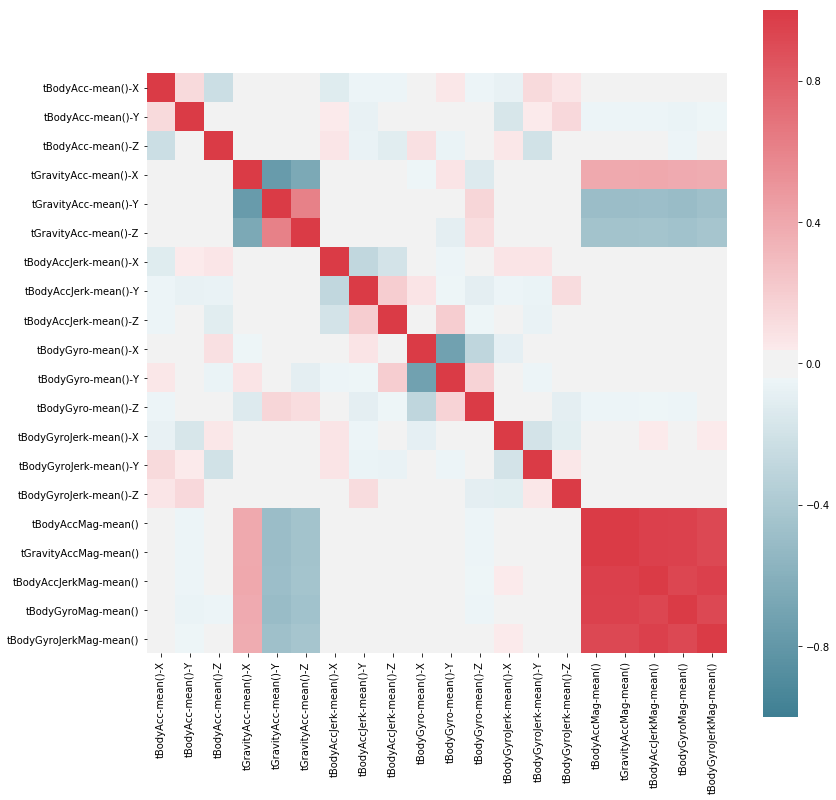

In [12]:
heatmap_corr(HAR_data.filter(items = core_features), fig_width = 13, fig_height = 13)

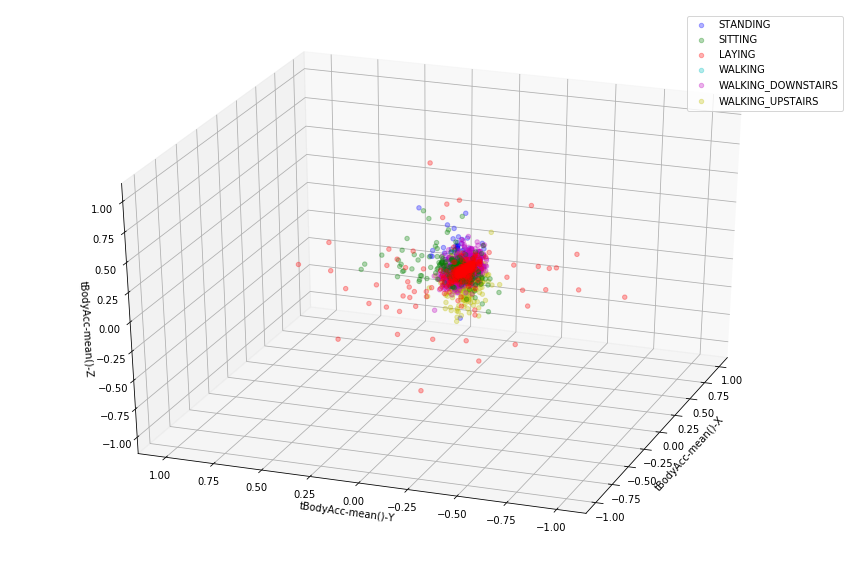

In [13]:
scatter_3D(xyz_list = [(HAR_data.loc[HAR_data.Activity == act,'tBodyAcc-mean()-X'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyAcc-mean()-Y'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyAcc-mean()-Z']) for act in HAR_data.Activity.unique()],
           xlab = 'tBodyAcc-mean()-X', ylab = 'tBodyAcc-mean()-Y', zlab = 'tBodyAcc-mean()-Z',
           angle = 200, alpha = 0.3, legend = HAR_data.Activity.unique(),fig_width = 15, fig_height = 10)

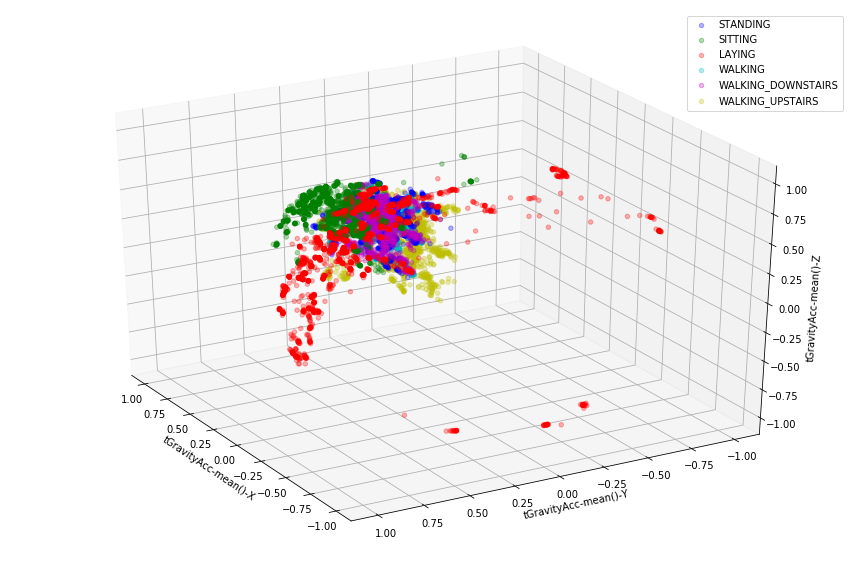

In [14]:
scatter_3D(xyz_list = [(HAR_data.loc[HAR_data.Activity == act,'tGravityAcc-mean()-X'],
                        HAR_data.loc[HAR_data.Activity == act,'tGravityAcc-mean()-Y'],
                        HAR_data.loc[HAR_data.Activity == act,'tGravityAcc-mean()-Z']) for act in HAR_data.Activity.unique()],
           xlab = 'tGravityAcc-mean()-X', ylab = 'tGravityAcc-mean()-Y', zlab = 'tGravityAcc-mean()-Z',
           angle = 150, alpha = 0.3, legend = HAR_data.Activity.unique(),fig_width = 15, fig_height = 10)

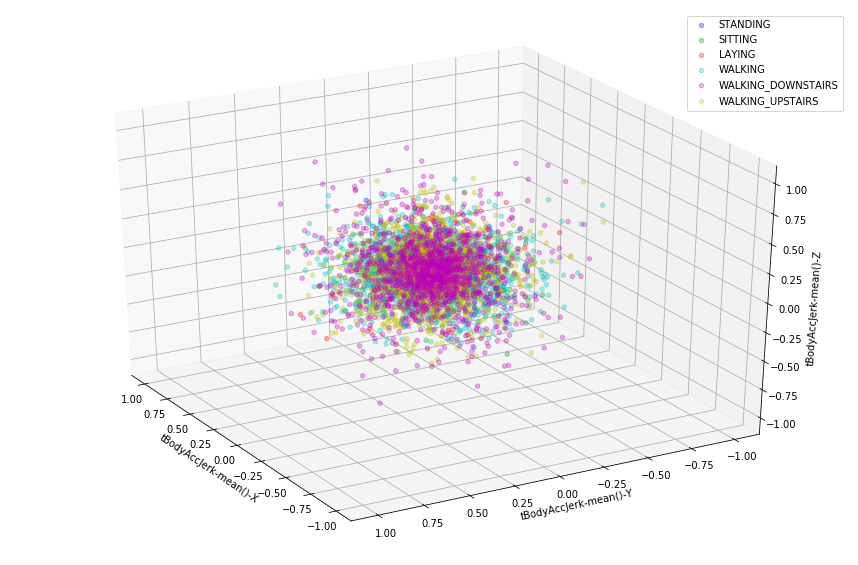

In [16]:
scatter_3D(xyz_list = [(HAR_data.loc[HAR_data.Activity == act,'tBodyAccJerk-mean()-X'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyAccJerk-mean()-Y'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyAccJerk-mean()-Z']) for act in HAR_data.Activity.unique()],
           xlab = 'tBodyAccJerk-mean()-X', ylab = 'tBodyAccJerk-mean()-Y', zlab = 'tBodyAccJerk-mean()-Z',
           angle = 150, alpha = 0.3, legend = HAR_data.Activity.unique(),fig_width = 15, fig_height = 10)

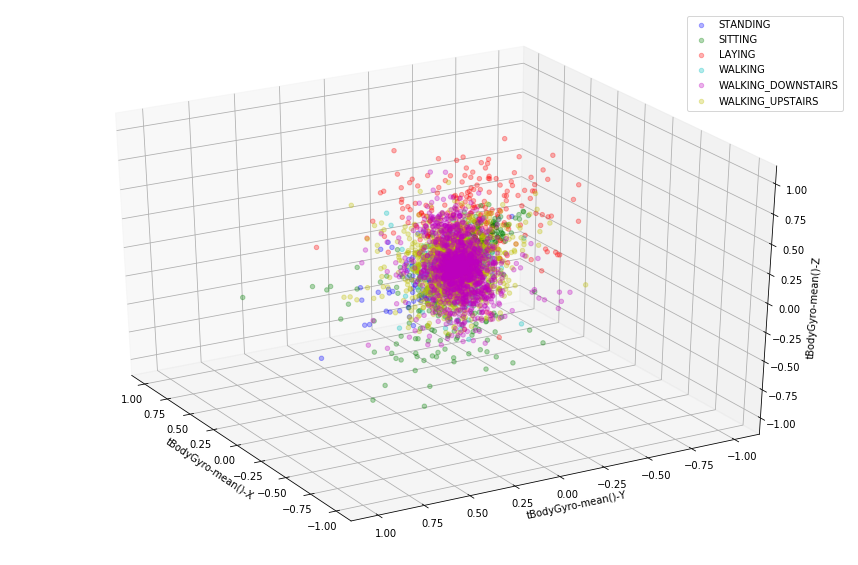

In [17]:
scatter_3D(xyz_list = [(HAR_data.loc[HAR_data.Activity == act,'tBodyGyro-mean()-X'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyGyro-mean()-Y'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyGyro-mean()-Z']) for act in HAR_data.Activity.unique()],
           xlab = 'tBodyGyro-mean()-X', ylab = 'tBodyGyro-mean()-Y', zlab = 'tBodyGyro-mean()-Z',
           angle = 150, alpha = 0.3, legend = HAR_data.Activity.unique(),fig_width = 15, fig_height = 10)

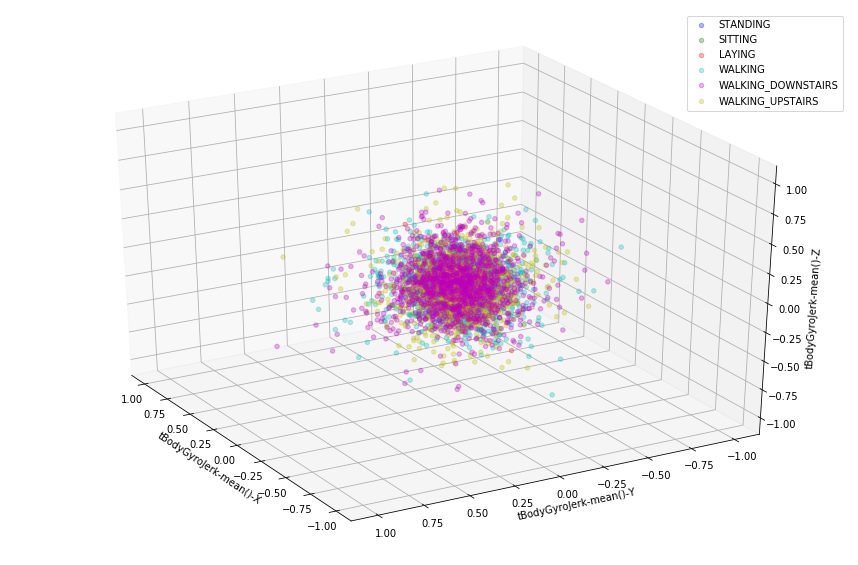

In [18]:
scatter_3D(xyz_list = [(HAR_data.loc[HAR_data.Activity == act,'tBodyGyroJerk-mean()-X'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyGyroJerk-mean()-Y'],
                        HAR_data.loc[HAR_data.Activity == act,'tBodyGyroJerk-mean()-Z']) for act in HAR_data.Activity.unique()],
           xlab = 'tBodyGyroJerk-mean()-X', ylab = 'tBodyGyroJerk-mean()-Y', zlab = 'tBodyGyroJerk-mean()-Z',
           angle = 150, alpha = 0.3, legend = HAR_data.Activity.unique(),fig_width = 15, fig_height = 10)

# Train-Test Split

Train-test split the data roughly based on 80-20

In [19]:
# How large is 80% of the data
round(HAR_data.shape[0]*0.8)

8239

In [20]:
# Find out which subject should be put in the train set in order to approximate 80% of the data
HAR_data.subject.value_counts().cumsum()

25      409
21      817
26     1209
30     1592
28     1974
24     2355
27     2731
23     3103
17     3471
16     3837
18     4201
19     4561
20     4915
1      5262
29     5606
3      5947
15     6275
13     6602
6      6927
14     7250
22     7571
12     7891
4      8208
11     8524
7      8832
2      9134
5      9436
10     9730
9     10018
8     10299
Name: subject, dtype: int64

**Note**: We can leave subjects `11`, `7`, `2`, `5`, `10`, `9`, `8` in the test set, which is approximately `20%` of the entire data

In [21]:
# Subject index for test set
test_subject = [11,7,2,5,10,9,8]

In [22]:
# Train set
train_data = HAR_data.loc[~HAR_data.subject.isin(test_subject),:]
train_data.drop(columns = 'subject', inplace = True)
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]
# Test set
test_data = HAR_data.loc[HAR_data.subject.isin(test_subject),:]
test_data.drop(columns = 'subject', inplace = True)
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Objective 1. Modeling
## 1. Logistic Regression

In [23]:
# Train a logistic regression
LR_model = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
LR_model = LR_model.fit(train_x, train_y)

In [24]:
# Prediction of logistic regression
test_pred_LR = LR_model.predict(test_x)

## 2. XGBoost

In [25]:
start = time.time()
# Initialize a xgboost model
xgb_model = xgb.XGBClassifier(objective = 'multi:softmax', 
                              n_estimators = 1000,
                              colsample_bytree = 0.8,
                              learning_rate = 0.1,
                              silent = True,
                              num_class = 6,
                              seed = seed)
# Train the model
xgb_model.fit(train_x, train_y, 
              eval_metric = 'merror', eval_set = [(train_x, train_y)], 
              early_stopping_rounds = 50, verbose = True)
end = time.time()
print('XGBoost took {:.2f} minutes to train'.format((end-start)/60))

[0]	validation_0-merror:0.071516
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.058236
[2]	validation_0-merror:0.052997
[3]	validation_0-merror:0.049951
[4]	validation_0-merror:0.049829
[5]	validation_0-merror:0.050439
[6]	validation_0-merror:0.047636
[7]	validation_0-merror:0.046174
[8]	validation_0-merror:0.0452
[9]	validation_0-merror:0.043616
[10]	validation_0-merror:0.042398
[11]	validation_0-merror:0.041423
[12]	validation_0-merror:0.039474
[13]	validation_0-merror:0.038986
[14]	validation_0-merror:0.038134
[15]	validation_0-merror:0.037524
[16]	validation_0-merror:0.037281
[17]	validation_0-merror:0.035575
[18]	validation_0-merror:0.034966
[19]	validation_0-merror:0.033869
[20]	validation_0-merror:0.032773
[21]	validation_0-merror:0.032773
[22]	validation_0-merror:0.031311
[23]	validation_0-merror:0.030458
[24]	validation_0-merror:0.029483
[25]	validation_0-merror:0.028996
[26]	validation_0-merror:0.029118
[27]	validation_0-merror:0.

In [26]:
# Prediction of XGBoost model
test_pred_xgb = xgb_model.predict(test_x)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Comparison of model performances

In [27]:
print('''
Accuracy: 
- Logistic Regression: {:.2f}%
- XGBoost Model: {:.2f}%
'''.format(100*accuracy_score(y_true = test_y, y_pred = test_pred_LR), 
           100*accuracy_score(y_true = test_y, y_pred = test_pred_xgb)))


Accuracy: 
- Logistic Regression: 93.64%
- XGBoost Model: 91.34%



In [117]:
print(classification_report(y_true = test_y, y_pred = test_pred_LR, 
                            target_names = ['LAYING','SITTING','STANDING',
                                            'WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       371
           SITTING       0.88      0.89      0.88       341
          STANDING       0.90      0.88      0.89       353
           WALKING       0.90      0.99      0.94       384
WALKING_DOWNSTAIRS       0.98      0.98      0.98       305
  WALKING_UPSTAIRS       0.97      0.88      0.93       337

       avg / total       0.94      0.94      0.94      2091



Confusion matrix, without normalization


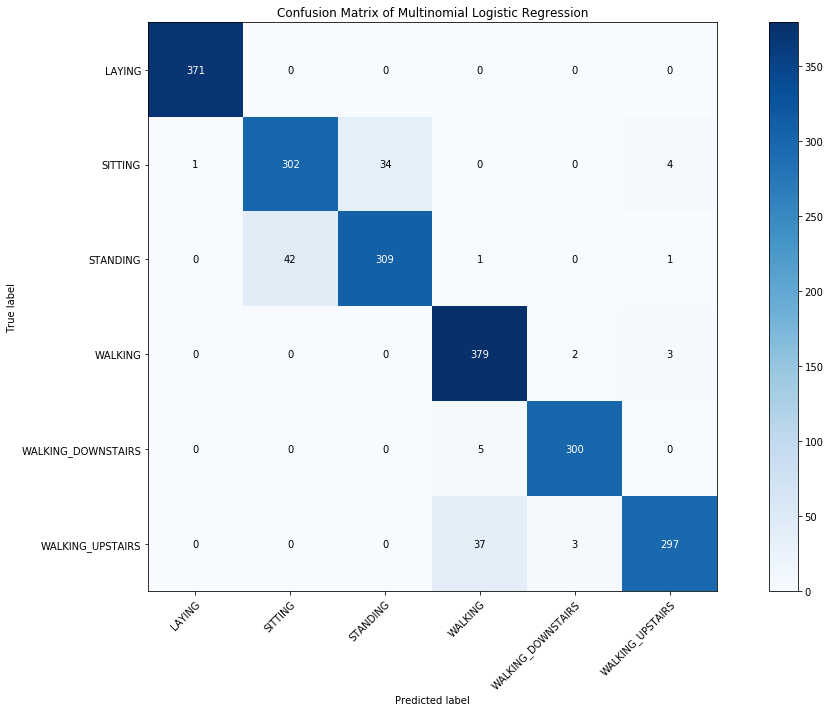

In [118]:
plot_confusion_matrix(y_true = test_y, y_pred = test_pred_LR, fig_width = 15, fig_height = 10, 
                      title = 'Confusion Matrix of Multinomial Logistic Regression')

In [112]:
print(classification_report(y_true = test_y, y_pred = test_pred_xgb, 
                            target_names = ['LAYING','SITTING','STANDING',
                                            'WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       371
           SITTING       0.78      0.86      0.82       341
          STANDING       0.86      0.77      0.81       353
           WALKING       0.92      0.97      0.95       384
WALKING_DOWNSTAIRS       0.94      0.99      0.97       305
  WALKING_UPSTAIRS       0.98      0.89      0.93       337

       avg / total       0.92      0.91      0.91      2091



Confusion matrix, without normalization


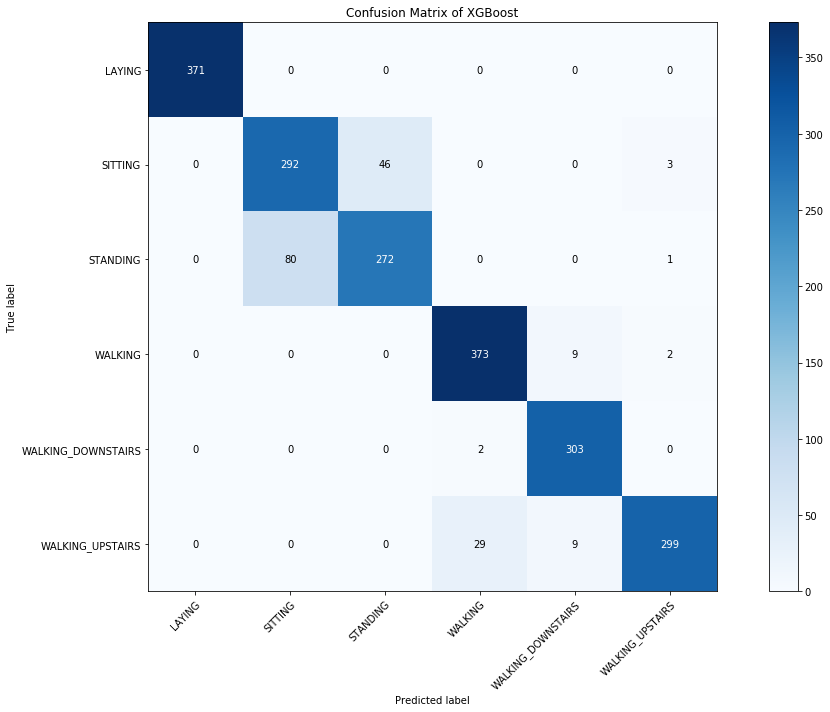

In [27]:
plot_confusion_matrix(y_true = test_y, y_pred = test_pred_xgb, fig_width = 15, fig_height = 10, title = 'Confusion Matrix of XGBoost')

**Conclusion**

Logistic Regression has slightly better accuracy than the XGBoost model for the test data set.

# Objective 2. Feature Selection

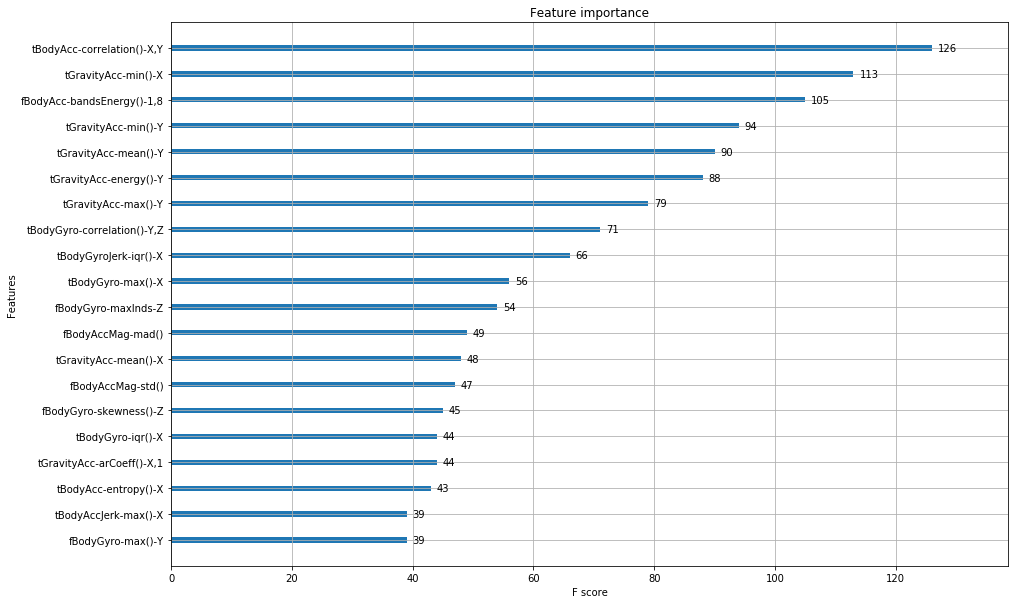

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(xgb_model, max_num_features = 20, ax= ax)
ax;

In [29]:
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

In [30]:
sorted_feature_importance = sorted(feature_importance.items(), key=lambda kv: kv[1], reverse = True)

In [73]:
xgb_acc = acc_vs_feature(xgb = xgb_model, acc_target = 90, 
                         X_train = train_x, y_train = train_y, 
                         X_test = test_x, y_test = test_y)

Accuracy: 91.34%
Thresh=0.033, n=1, Accuracy: 32.19%
Thresh=0.030, n=2, Accuracy: 56.67%
Thresh=0.027, n=3, Accuracy: 78.14%
Thresh=0.025, n=4, Accuracy: 79.39%
Thresh=0.024, n=5, Accuracy: 79.15%
Thresh=0.023, n=6, Accuracy: 79.05%
Thresh=0.021, n=7, Accuracy: 79.05%
Thresh=0.019, n=8, Accuracy: 78.19%
Thresh=0.017, n=9, Accuracy: 79.63%
Thresh=0.015, n=10, Accuracy: 80.20%
Thresh=0.014, n=11, Accuracy: 83.79%
Thresh=0.013, n=12, Accuracy: 86.27%
Thresh=0.013, n=13, Accuracy: 86.27%
Thresh=0.012, n=14, Accuracy: 85.75%
Thresh=0.012, n=15, Accuracy: 86.13%
Thresh=0.012, n=17, Accuracy: 86.66%
Thresh=0.012, n=17, Accuracy: 86.66%
Thresh=0.011, n=18, Accuracy: 86.66%
Thresh=0.010, n=20, Accuracy: 88.19%
Thresh=0.010, n=20, Accuracy: 88.19%
Thresh=0.010, n=22, Accuracy: 88.14%
Thresh=0.010, n=22, Accuracy: 88.14%
Thresh=0.010, n=23, Accuracy: 88.47%
Thresh=0.009, n=25, Accuracy: 88.19%
Thresh=0.009, n=25, Accuracy: 88.19%
Thresh=0.009, n=27, Accuracy: 88.52%
Thresh=0.009, n=27, Accuracy: 

,n,accuracy
0,1,32.1856
1,2,56.6714
2,3,78.1444
3,4,79.3879
4,5,79.1487
5,6,79.0531
6,7,79.0531
7,8,78.1923
8,9,79.627
9,10,80.2009


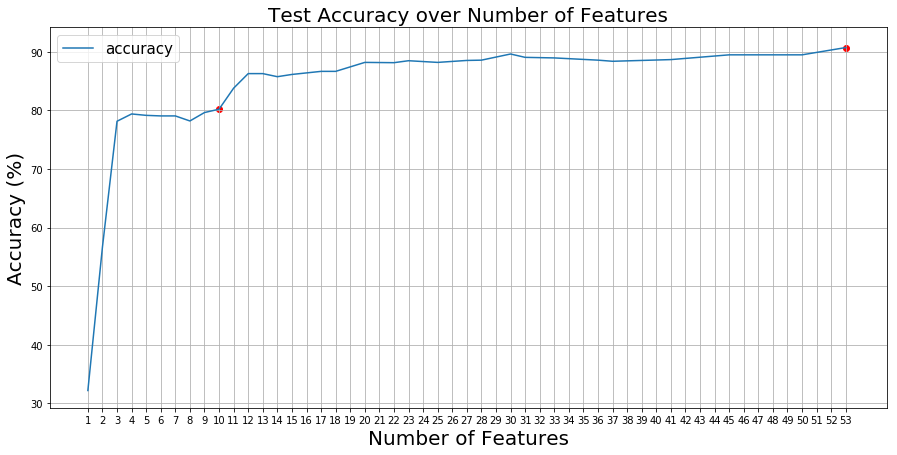

In [138]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(xgb_acc.n, xgb_acc.accuracy)
ax.legend(['accuracy'], prop={'size':15}); ax.set_title('Test Accuracy over Number of Features', fontsize = 20)
ax.set_xlabel('Number of Features', fontsize = 20); ax.set_ylabel('Accuracy (%)', fontsize = 20); 
ax.grid(); ax.set_xticks(range(1,54));

ax.scatter(xgb_acc.n[9], xgb_acc.accuracy[9], c = 'r')
ax.scatter(xgb_acc.n[52], xgb_acc.accuracy[52], c = 'r')

# Objective 3. PCA

In [78]:
xgb_pca = xgb.XGBClassifier(objective = 'multi:softmax', 
                            n_estimators = 1000,
                            colsample_bytree = 0.8,
                            learning_rate = 0.1,
                            silent = True,
                            num_class = 6,
                            seed = seed)

In [79]:
xgb_pca_acc = acc_vs_pca(xgb_pca, 
                        X_train = train_x, y_train = train_y,
                        X_test = test_x, y_test = test_y, threshold = 0.9)

n = 1, accuracy = 42.37%
n = 2, accuracy = 54.95%
n = 3, accuracy = 65.14%
n = 4, accuracy = 74.46%
n = 5, accuracy = 75.90%
n = 6, accuracy = 77.47%
n = 7, accuracy = 79.48%
n = 8, accuracy = 82.50%
n = 9, accuracy = 82.02%
n = 10, accuracy = 82.54%
n = 11, accuracy = 83.17%
n = 12, accuracy = 84.79%
n = 13, accuracy = 85.99%
n = 14, accuracy = 87.04%
n = 15, accuracy = 86.42%
n = 16, accuracy = 86.90%
n = 17, accuracy = 87.80%
n = 18, accuracy = 87.85%
n = 19, accuracy = 88.04%
n = 20, accuracy = 87.52%
n = 21, accuracy = 87.85%
n = 22, accuracy = 87.57%
n = 23, accuracy = 88.28%
n = 24, accuracy = 87.66%
n = 25, accuracy = 88.28%
n = 26, accuracy = 88.04%
n = 27, accuracy = 88.52%
n = 28, accuracy = 88.76%
n = 29, accuracy = 89.14%
n = 30, accuracy = 89.14%
n = 31, accuracy = 89.29%
n = 32, accuracy = 89.43%
n = 33, accuracy = 89.48%
n = 34, accuracy = 89.62%
n = 35, accuracy = 90.29%


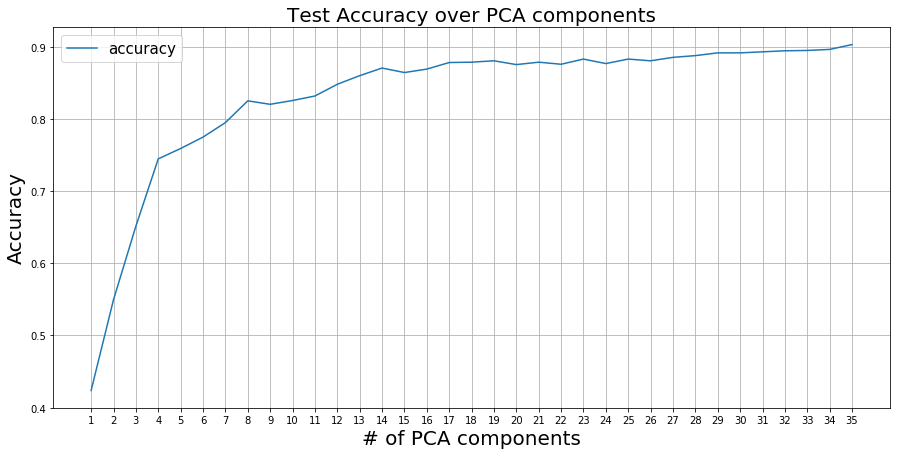

In [137]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(xgb_pca_acc.n, xgb_pca_acc.accuracy)
ax.legend(['accuracy'], prop={'size':15}); ax.set_title('Test Accuracy over PCA components', fontsize = 20)
ax.set_xlabel('# of PCA components', fontsize = 20); ax.set_ylabel('Accuracy', fontsize = 20); 
ax.grid(); ax.set_xticks(range(1,36));